# Incorporating lightcurves

The goal of this notebook is to demonstrate the use of lightcurves within `sorcha`.

This will be done in two different ways:
- We will use the community tools part of the `sorcha-addons`(https://github.com/dirac-institute/sorcha-addons) package
- We will implement a custom lightcurve, and use it inside the code

The idea is that the user can, in principle, implement their own lightcurves, and incorporate them in their simulation. The goal of `sorcha-addons` is for both the development team, as well as for the community, to share their implementations of custom lightcurve models. 

In [1]:
import pandas as pd
import numpy as np
import astropy.units as u
from astroquery.jplhorizons import Horizons
from sorcha_addons.lightcurve.sinusoidal.sinusoidal_lightcurve import SinusoidalLightCurve
from sorcha.modules.PPCalculateApparentMagnitudeInFilter import PPCalculateApparentMagnitudeInFilter
import matplotlib.pyplot as plt

This notebook will not use a realistic set of observations (as in the `demo_ApparentMagnitudeValidation` notebook), but rather create a toy scenario with a simple to understand and interpret set of results. The general structure of the notebook will be the same.

We will create a dataframe for observations in a similar structure as in the `demo_ApparentMagnitudeValidation` notebook:

In [2]:
observations_df = pd.DataFrame(
    {
        "fieldMJD_TAI": np.linspace(
            0, 100, 1001
        ),  # time of observation - note these values are bogus, we only care about the Delta t for this demo
        "H_filter": 10 * np.ones(1001),
        "GS": 0.15 * np.ones(1001),
        "G1": 0.62 * np.ones(1001),
        "G2": 0.14 * np.ones(1001),
        "G12": 0.68 * np.ones(1001),
        "S": 0.04 * np.ones(1001),
        "Range_LTC_km": 1.495978707e8 * np.ones(1001),  # 1 au
        "Obj_Sun_LTC_km": 1.495978707e8 * np.ones(1001),  # 1 au
        "phase_deg": np.linspace(0, 10, 1001),
    }
)  # some phase angle variation so we can see the phase curve on top of the lightcurve

In [3]:
observations_df

,fieldMJD_TAI,H_filter,GS,G1,G2,G12,S,Range_LTC_km,Obj_Sun_LTC_km,phase_deg
0,0.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.00
1,0.1,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.01
2,0.2,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.02
3,0.3,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.03
4,0.4,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.04
...,...,...,...,...,...,...,...,...,...,...
996,99.6,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.96
997,99.7,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.97
998,99.8,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.98
999,99.9,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.99


Now we calculate the magnitude using the various models in PPCalculateApparentMagnitudeInFilter.

In [4]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "HG", "r", "HG_mag")
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "HG12", "r", "HG12_mag")
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "HG1G2", "r", "HG1G2_mag")
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "linear", "r", "linear_mag")
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "none", "r", "Simple_mag")

In [5]:
observations_df

,fieldMJD_TAI,H_filter,GS,G1,G2,G12,S,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,HG_mag,HG12_mag,HG1G2_mag,linear_mag,Simple_mag
0,0.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.00,10.000000,10.000000,10.000000,10.0000,10.0
1,0.1,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.01,10.001390,10.000361,10.000366,10.0004,10.0
2,0.2,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.02,10.002776,10.000884,10.000884,10.0008,10.0
3,0.3,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.03,10.004158,10.001562,10.001549,10.0012,10.0
4,0.4,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.04,10.005537,10.002388,10.002352,10.0016,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,99.6,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.96,10.656917,10.628635,10.624403,10.3984,10.0
997,99.7,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.97,10.657299,10.629045,10.624827,10.3988,10.0
998,99.8,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.98,10.657681,10.629454,10.625251,10.3992,10.0
999,99.9,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.99,10.658064,10.629864,10.625675,10.3996,10.0


Now we can plot the magnitudes and compare them.

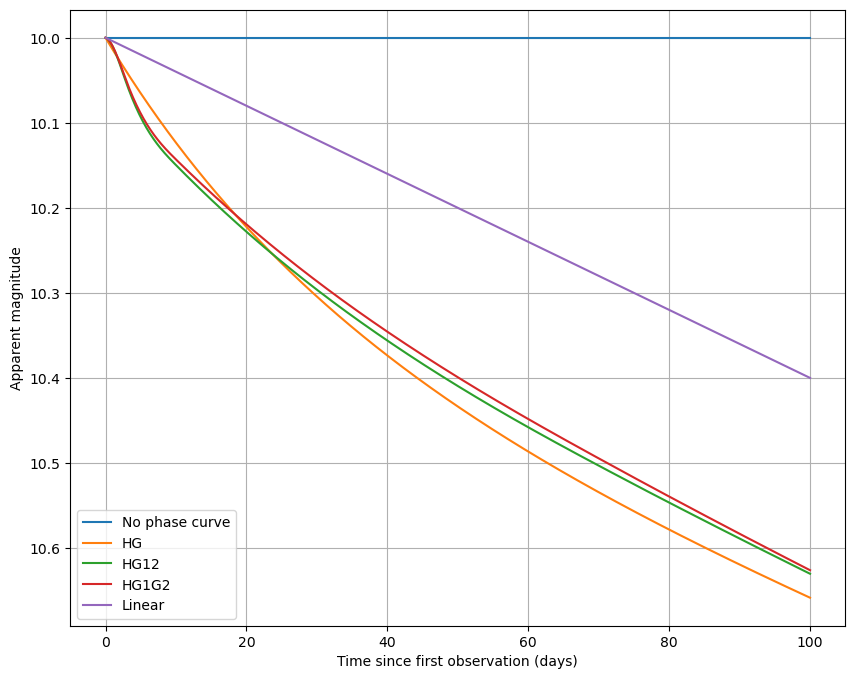

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(observations_df["fieldMJD_TAI"], observations_df["Simple_mag"], linestyle="-", label="No phase curve")
ax.plot(observations_df["fieldMJD_TAI"], observations_df["HG_mag"], label="HG")
ax.plot(observations_df["fieldMJD_TAI"], observations_df["HG12_mag"], label="HG12")
ax.plot(observations_df["fieldMJD_TAI"], observations_df["HG1G2_mag"], label="HG1G2")
ax.plot(observations_df["fieldMJD_TAI"], observations_df["linear_mag"], label="Linear")

ax.legend()
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

The effect of the lightcurve is to add an extra term to the apparent magnitude, that, in principle, can be a function of the characteristics of the observations, such as time of observation, phase angle or topocentric and heliocentric distances. The entire `observational_df` dataframe is exposed to the lightcurve, so any dependencies can be added. 

Let's use the basic sinusoidal lightcurve from `sorcha_addons`. We need the following columns in our dataframe:

    * ``LCA`` - lightcurve amplitude [magnitudes].
    * ``Period`` - period of the sinusoidal oscillation [days]. Should be a positive value.
    * ``Time0`` - phase for the light curve [days].

Let's create a lightcurve with a period of 20 days, phased so that the first observation is at zero variation, and with 0.5 mag peak-to-peak amplitude.

In [7]:
from sorcha.lightcurves.lightcurve_registration import LC_METHODS, update_lc_subclasses

# LC_METHODS is the dictionary that contains all lightcurve implementations
# update_lc_subclasses adds newly defined classes to this dictionary
# this is run by default inside sorcha - we are just showing it here for completeness
update_lc_subclasses()
print(LC_METHODS)

{'identity': <class 'sorcha.lightcurves.identity_lightcurve.IdentityLightCurve'>, 'sinusoidal': <class 'sorcha_addons.lightcurve.sinusoidal.sinusoidal_lightcurve.SinusoidalLightCurve'>}


In [8]:
observations_df["LCA"] = 0.25  # note peak-to-peak is 2LCA!
observations_df["Period"] = 20.0
observations_df["Time0"] = 0.0

In [9]:
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "none", "r", "LCA_mag", "sinusoidal"
)
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG", "r", "LCA_HG_mag", "sinusoidal"
)
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG12", "r", "LCA_HG12_mag", "sinusoidal"
)
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "LCA_HG1G2_mag", "sinusoidal"
)
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "linear", "r", "LCA_linear_mag", "sinusoidal"
)

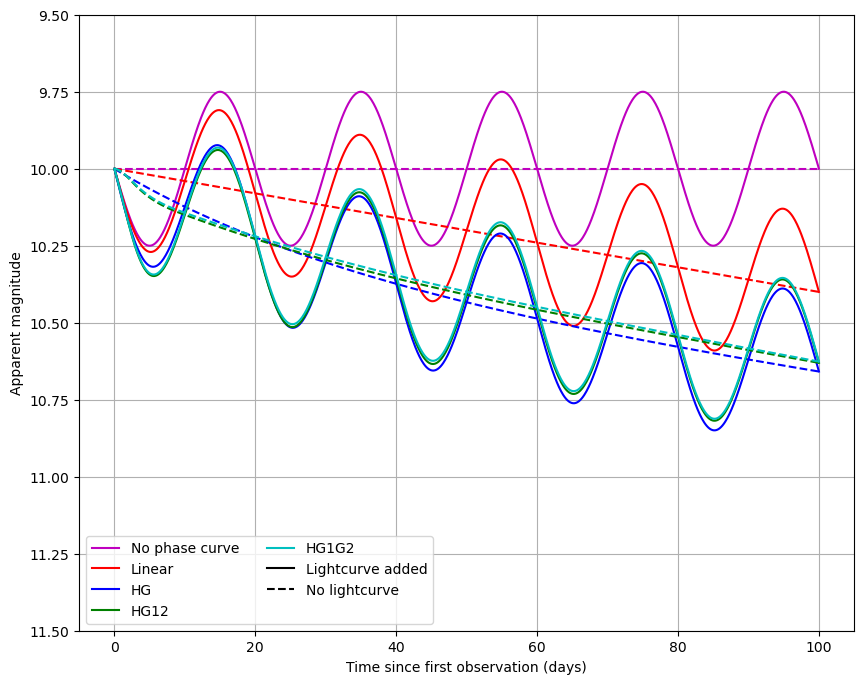

In [10]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["Simple_mag"],
    linestyle="--",
    label="__none__",
    color="m",
)
ax.plot(
    observations_df["fieldMJD_TAI"], observations_df["LCA_mag"], linestyle="-", label="__none__", color="m"
)

ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["linear_mag"],
    linestyle="--",
    label="__none__",
    color="r",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCA_linear_mag"],
    linestyle="-",
    label="__none__",
    color="r",
)


ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG_mag"],
    linestyle="--",
    label="__none__",
    color="b",
)
ax.plot(
    observations_df["fieldMJD_TAI"], observations_df["LCA_HG_mag"], linestyle="-", label="__none__", color="b"
)

ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG12_mag"],
    linestyle="--",
    label="__none__",
    color="g",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCA_HG12_mag"],
    linestyle="-",
    label="__none__",
    color="g",
)

ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    label="__none__",
    color="c",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCA_HG1G2_mag"],
    linestyle="-",
    label="__none__",
    color="c",
)


custom_legend = [
    Line2D([0], [0], color="m", linestyle="-"),
    Line2D([0], [0], color="r", linestyle="-"),
    Line2D([0], [0], color="b", linestyle="-"),
    Line2D([0], [0], color="g", linestyle="-"),
    Line2D([0], [0], color="c", linestyle="-"),
    Line2D([0], [0], color="k", linestyle="-"),
    Line2D([0], [0], color="k", linestyle="--"),
]

ax.legend(
    custom_legend,
    ["No phase curve", "Linear", "HG", "HG12", "HG1G2", "Lightcurve added", "No lightcurve"],
    ncol=2,
)
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
ax.set_ylim(9.5, 11.5)
plt.gca().invert_yaxis()
plt.grid()
plt.show()

### Incorporating your own lightcurve

You can also implement a custom lightcurve. To do so, you need to inherit from the `AbstractLightCurve` class inside `sorcha`. Let's implement a simple extension of this sinusoidal model, where we have two sine terms at once. The implementation will be very similar to the `SinusoidalLightCurve` class used above.

In [11]:
from sorcha.lightcurves.base_lightcurve import AbstractLightCurve

from sorcha.lightcurves.base_lightcurve import AbstractLightCurve

from typing import List
import pandas as pd
import numpy as np


class DoubleSinusoidalLightCurve(AbstractLightCurve):
    def __init__(
        self, required_column_names: List[str] = ["fieldMJD_TAI", "LCA", "Period1", "Period2", "Time0"]
    ) -> None:
        super().__init__(required_column_names)

    def compute(self, df: pd.DataFrame) -> np.array:
        # Verify that the input data frame contains each of the required columns.
        self._validate_column_names(df)

        time1 = 2 * np.pi * (df["fieldMJD_TAI"] - df["Time0"]) / df["Period1"]
        time2 = 2 * np.pi * (df["fieldMJD_TAI"] - df["Time0"]) / df["Period2"]

        return df["LCA"] * np.sin(time1) * np.sin(time2)

    # this method defines the same of the class inside LC_METHODS
    @staticmethod
    def name_id() -> str:
        return "doublesinusoidal"

In [12]:
update_lc_subclasses()
print(LC_METHODS)

{'identity': <class 'sorcha.lightcurves.identity_lightcurve.IdentityLightCurve'>, 'sinusoidal': <class 'sorcha_addons.lightcurve.sinusoidal.sinusoidal_lightcurve.SinusoidalLightCurve'>, 'doublesinusoidal': <class '__main__.DoubleSinusoidalLightCurve'>}


In [13]:
# let's add the required columns that are different from the sinusoidal lightcurve
observations_df["Period1"] = 20.0
observations_df["Period2"] = 4.0

In [14]:
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "none", "r", "DLCA_mag", "doublesinusoidal"
)
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG", "r", "DLCA_HG_mag", "doublesinusoidal"
)
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG12", "r", "DLCA_HG12_mag", "doublesinusoidal"
)
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "DLCA_HG1G2_mag", "doublesinusoidal"
)
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "linear", "r", "DLCA_linear_mag", "doublesinusoidal"
)

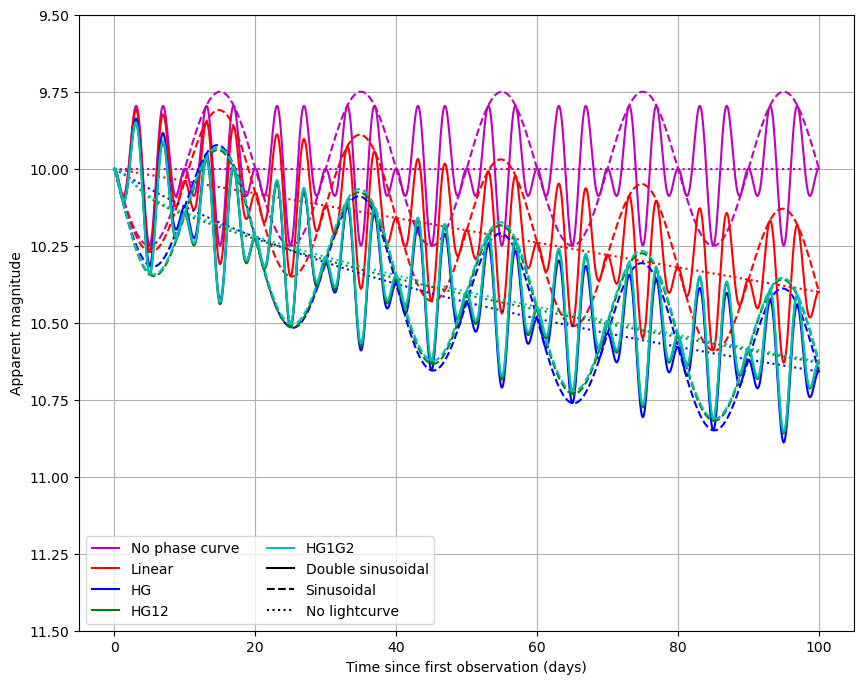

In [15]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["Simple_mag"],
    linestyle=":",
    label="__none__",
    color="m",
)
ax.plot(
    observations_df["fieldMJD_TAI"], observations_df["LCA_mag"], linestyle="--", label="__none__", color="m"
)
ax.plot(
    observations_df["fieldMJD_TAI"], observations_df["DLCA_mag"], linestyle="-", label="__none__", color="m"
)


ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["linear_mag"],
    linestyle=":",
    label="__none__",
    color="r",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCA_linear_mag"],
    linestyle="--",
    label="__none__",
    color="r",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["DLCA_linear_mag"],
    linestyle="-",
    label="__none__",
    color="r",
)


ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG_mag"],
    linestyle=":",
    label="__none__",
    color="b",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCA_HG_mag"],
    linestyle="--",
    label="__none__",
    color="b",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["DLCA_HG_mag"],
    linestyle="-",
    label="__none__",
    color="b",
)

ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG12_mag"],
    linestyle=":",
    label="__none__",
    color="g",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCA_HG12_mag"],
    linestyle="--",
    label="__none__",
    color="g",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["DLCA_HG12_mag"],
    linestyle="-",
    label="__none__",
    color="g",
)

ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG1G2_mag"],
    linestyle=":",
    label="__none__",
    color="c",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCA_HG1G2_mag"],
    linestyle="--",
    label="__none__",
    color="c",
)
ax.plot(
    observations_df["fieldMJD_TAI"],
    observations_df["DLCA_HG1G2_mag"],
    linestyle="-",
    label="__none__",
    color="c",
)


custom_legend = [
    Line2D([0], [0], color="m", linestyle="-"),
    Line2D([0], [0], color="r", linestyle="-"),
    Line2D([0], [0], color="b", linestyle="-"),
    Line2D([0], [0], color="g", linestyle="-"),
    Line2D([0], [0], color="c", linestyle="-"),
    Line2D([0], [0], color="k", linestyle="-"),
    Line2D([0], [0], color="k", linestyle="--"),
    Line2D([0], [0], color="k", linestyle=":"),
]

ax.legend(
    custom_legend,
    ["No phase curve", "Linear", "HG", "HG12", "HG1G2", "Double sinusoidal", "Sinusoidal", "No lightcurve"],
    ncol=2,
)
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
ax.set_ylim(9.5, 11.5)
plt.gca().invert_yaxis()
plt.grid()
plt.show()